What is up with the g430l?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
import stistools
from astropy.convolution import convolve, Box1DKernel
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


sort photometry first

In [4]:
phottabs = glob.glob('../photometry/vizer_tables/*.vot')
phottabs

['../photometry/vizer_tables/GJ_163.vot',
 '../photometry/vizer_tables/Trappist-1.vot',
 '../photometry/vizer_tables/GJ_1132.vot',
 '../photometry/vizer_tables/GJ_849.vot',
 '../photometry/vizer_tables/L_980-5.vot',
 '../photometry/vizer_tables/GJ_676A.vot',
 '../photometry/vizer_tables/LTT_1445.vot',
 '../photometry/vizer_tables/GJ_699.vot',
 '../photometry/vizer_tables/GJ_15A.vot',
 '../photometry/vizer_tables/GJ_674.vot',
 '../photometry/vizer_tables/GJ_729.vot',
 '../photometry/vizer_tables/LHS_2686.vot',
 '../photometry/vizer_tables/GJ_649.vot']

../photometry/vizer_tables/GJ_163.vot
../photometry/vizer_tables/Trappist-1.vot
../photometry/vizer_tables/GJ_1132.vot


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


../photometry/vizer_tables/GJ_849.vot
../photometry/vizer_tables/L_980-5.vot
../photometry/vizer_tables/GJ_676A.vot


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


../photometry/vizer_tables/LTT_1445.vot
../photometry/vizer_tables/GJ_699.vot
../photometry/vizer_tables/GJ_15A.vot
../photometry/vizer_tables/GJ_674.vot


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykerne

../photometry/vizer_tables/GJ_729.vot
../photometry/vizer_tables/LHS_2686.vot
../photometry/vizer_tables/GJ_649.vot


/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:422: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/lib/python3.7/site-packages/ipykerne

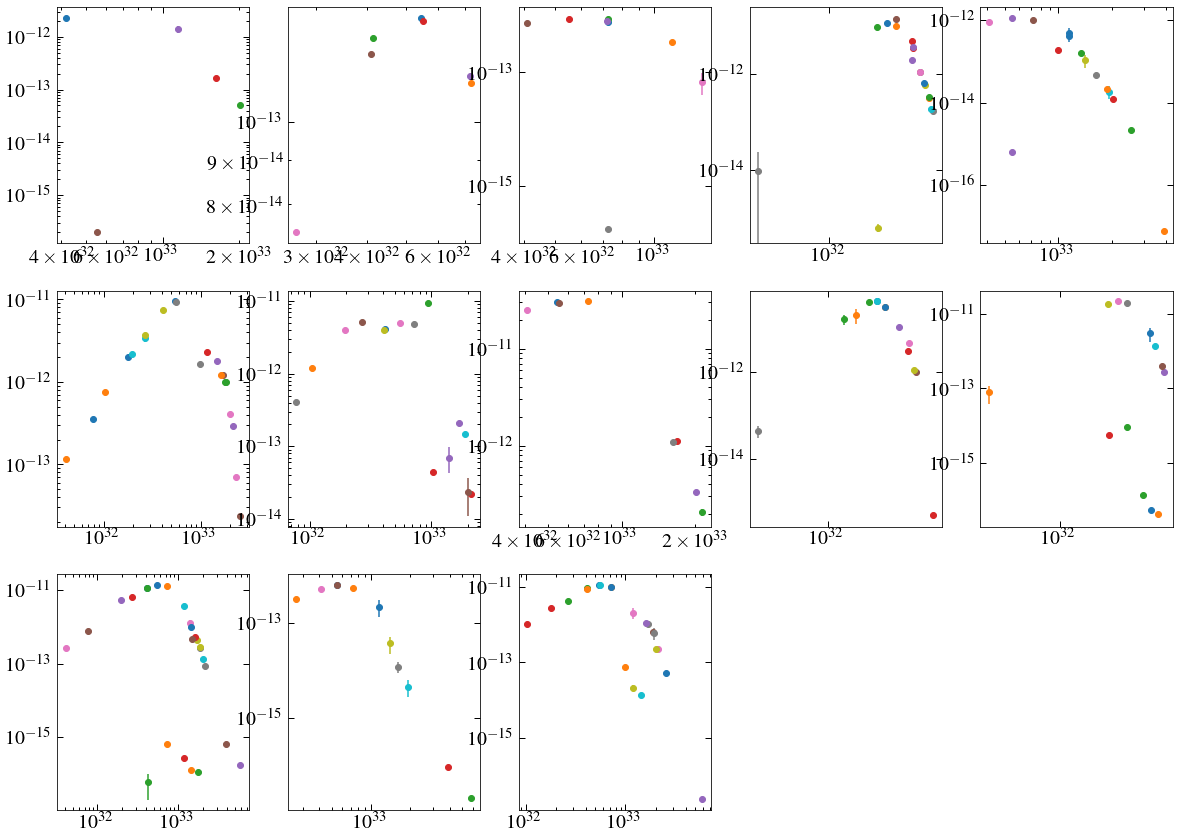

In [20]:
c = 2.998e8*u.m/u.s
plt.figure(figsize =(20, 20))
for i, phottab in enumerate(phottabs):
    print(phottab)
    votable = parse(phottab)
    table = votable.get_first_table()
    data = table.array
    mask = ~data['sed_eflux'].mask
    masked_data = data[mask].data
    filters = np.unique(masked_data['sed_filter'].data)
    w = []
    f = []
    e = []
    for filter in filters:
        w1 = np.mean(masked_data['sed_freq'][masked_data['sed_filter']==filter])*1e9*u.Hz.to(u.AA, equivalencies=u.spectral())
        fj1 = masked_data['sed_flux'][masked_data['sed_filter']==filter]
        e1 = masked_data['sed_eflux'][masked_data['sed_filter']==filter]
        if len(fj1) >1:
            fj_av = np.average(fj1, weights = (1/(e1**2)))
            e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
        else:
            fj_av, e1_av = fj1[0], e1[0]
        f1 = fj_av*u.Jy.to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(3500 * u.AA)) 
        w.append(w1)
        f.append(f1)
        e.append((e1_av*f1)/fj_av)
   # plt.figure('sed', figsize=(5,5))
    plt.subplot(4, 5, i+1)
    for i in range(len(w)):
        if e[i] !=0.0:
            plt.errorbar(w[i], f[i], yerr=e[i], marker='o', ls='none', label = filters[i])
        #else:
         #   plt.errorbar(w[i], f[i], yerr=f[i]*0.1, marker='o', ls='none', uplims=True,label = filters[i])
    plt.yscale('log')
    plt.xscale('log')
plt.show()
    #plt.legend()
        

In [15]:
data

masked_array(data=[(254.5368786472, 25.7441602865, b'I/239/hip_main', b'recno=82975', 541430.0, 0.47999998927116394, --, b'Johnson:V'),
                   (254.5368786472, 25.7441602865, b'I/239/hip_main', b'recno=82975', 563630.0, 0.43700000643730164, 0.00800000037997961, b'HIP:VT'),
                   (254.5368786472, 25.7441602865, b'I/239/hip_main', b'recno=82975', 713280.0, 0.09000000357627869, 0.005200000014156103, b'HIP:BT'),
                   (254.5368786472, 25.7441602865, b'I/239/hip_main', b'recno=82975', 745750.0, 0.4869999885559082, 0.0010000000474974513, b'HIP:Hp'),
                   (254.5368771918, 25.7441454088, b'I/239/tyc_main', b'recno=184843', 541430.0, 0.49799999594688416, --, b'Johnson:V'),
                   (254.5368771918, 25.7441454088, b'I/239/tyc_main', b'recno=184843', 563630.0, 0.43700000643730164, 0.00800000037997961, b'HIP:VT'),
                   (254.5368771918, 25.7441454088, b'I/239/tyc_main', b'recno=184843', 713280.0, 0.09000000357627869, 0.0052